In [1]:
using LinearAlgebra
using PolyChaos
using QuadGK
using Plots
using Base.Threads

println(Threads.nthreads())


function SpectralFunc(input::AbstractString, D::Float64, g::Float64)
    inband = x -> (-D <= x <= D)
        
    if input == "flat"
        J = x -> inband(x) ? 1/(2D) : 0.0
    elseif input == "elliptical"
        J = x -> inband(x) ? sqrt(1 - (x/D)^2) : 0.0
    elseif input == "ohmic"
        J = x -> inband(x) ? abs(x) : 0.0
    elseif input == "lorentzian"
        J = x -> 1/(1 + (x/D)^2)
    else
        error("spectral function type not recognized")
    end
    # normalization
    norm = quadgk(J, -D, D)[1]           
    Jnorm = x -> g*D/pi * J(x) / norm
    return Jnorm
end

function ThermofieldTransform(J, beta::Float64, mu::Float64) #spectral function, inverse temp, chemical potential
    """thermofield purification using fermi function ancilla"""
    fermi(k) = 1/(1 + exp(beta*k - beta*mu))
    J1 = w -> J(w) * fermi(w) #filled mode spectral density
    J2 = w -> J(w) * (1 - fermi(w)) #empty mode spectral density
    return J1, J2
end

function ChainMap(J, N::Int64, D::Float64)
    """calculates family of monic orthogonal polynomials w.r.t the measure J(x) up to the Nth term.
    returns the coefficients alpha and beta from the recurrence relation of the family."""
    supp = (-D, D)
    meas = Measure("bath", J, supp, false, Dict())
    ortho_poly = OrthoPoly("bath_op", N, meas; Nquad=100000)   
    chain = coeffs(ortho_poly)                                  
    Es = chain[1:N,1] #site energies
    ts = sqrt.(chain[1:N,2]) #site hoppings (first term is system hopping)
    return Es, ts
end

function PrepareCorrs(N, sys_occ)                
    
    I_L  = I(N)                
    Z_L  = zeros(N, N)

    # assemble C0
    C0 = zeros(ComplexF64, 2N+1, 2N+1)
    C0[N+1,N+1] = sys_occ + 0im
    C0[1:N, 1:N] .= I_L    
    C0[N+2:end, N+2:end] .= Z_L
    C0 = Hermitian(C0)
    return C0
end


function HamiltonianCorrs(N::Int64, Es::Float64, E1, h1, E2, h2)
"""exact Hamiltonian for chain mapped OQS"""
    E1 = reverse(E1) #empty chain onsite energies
    h1 = reverse(h1) #empty chain NN couplings
    d = Vector{Float64}(undef, 2*N+1)     # diagonal 
    e = Vector{Float64}(undef, 2*N)       # off-diagonal
    d[1:N] .= E1
    d[N+1] = Es
    d[N+2:2N+1] .= E2
    e[1:N] .= h1
    e[N+1:2N] .= h2
    H = SymTridiagonal(d, e)            # Hermitian and tridiagonal
    return H
end

function EvolveCorrs(C0, H, dt, N)
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    C0 = Matrix(C0)
    H = Matrix(H)
    
    # Pre-compute the single step propagator
    U_dt = exp(-im * dt * H) 
    U_dt_dag = U_dt'
    
    C_curr = C0
    push!(Cs, C_curr)
    
    step = 1
    ans = false
    
    while ans == false 
        # Update state iteratively
        C_curr = U_dt * C_curr * U_dt_dag
        push!(Cs, C_curr)
        
        if step % 100 == 0
            nSys = [real(M[N+1,N+1]) for M in Cs[end-100:end]]
            min,max = extrema(nSys)
            ans = (max-min < 0.001)
        end
        step += 1
        # Safety break to prevent infinite loops if it doesn't settle
        if step > 2000; break; end 
    end
    return Cs
end

function BLP(rho1, rho2) #arrays over time
    l1 = length(rho1)
    l2 = length(rho2)

    if l1 < l2
        rho1 = vcat(rho1, rho1[end].*ones(l2-l1))
    elseif l1 > l2
        rho2 = vcat(rho2, rho2[end].*ones(l1-l2))
    end
    
    TD = 0.5 .* abs.(rho1 .- rho2) #single-particle trace distance
    sigma = TD[2:end] .- TD[1:end-1] #change in trace distance
    meas = sum(sigma[sigma .>= 0.0]) #sum over all positive change in trace distance
    return meas
end

8


BLP (generic function with 1 method)

In [2]:
dt = 0.1
N = 100

D = 1.0
mu = 0.1
Es = 0.0

betas = collect(1.0:1.0:100.0)
gs = collect(0.01:0.01:1.0)

BLP_data = zeros(length(gs),length(betas))
for (i,g) in enumerate(gs)
    J = SpectralFunc("elliptical", D, g)
    for j in eachindex(betas)
        beta = betas[j]
        J1, J2 = ThermofieldTransform(J, beta, mu)
        E1, h1 = ChainMap(J1, N, D)
        E2, h2 = ChainMap(J2, N, D)
        C0f = PrepareCorrs(N, 1.0) 
        C0e = PrepareCorrs(N, 0.0)
        H = HamiltonianCorrs(N, Es, E1, h1, E2, h2)
        Csf = EvolveCorrs(C0f, H, dt, N)
        Cse = EvolveCorrs(C0e, H, dt, N)
        rho1 = [real(C[N+1, N+1]) for C in Csf]
        rho2 = [real(C[N+1, N+1]) for C in Cse]
        BLP_data[i,j] = BLP(rho1,rho2)
    end
    println("step $i of $(length(gs)) complete")
end

step 1 of 100 complete
step 2 of 100 complete
step 3 of 100 complete
step 4 of 100 complete
step 5 of 100 complete
step 6 of 100 complete
step 7 of 100 complete
step 8 of 100 complete
step 9 of 100 complete
step 10 of 100 complete
step 11 of 100 complete
step 12 of 100 complete
step 13 of 100 complete
step 14 of 100 complete
step 15 of 100 complete
step 16 of 100 complete
step 17 of 100 complete
step 18 of 100 complete
step 19 of 100 complete
step 20 of 100 complete
step 21 of 100 complete
step 22 of 100 complete
step 23 of 100 complete
step 24 of 100 complete
step 25 of 100 complete
step 26 of 100 complete
step 27 of 100 complete
step 28 of 100 complete
step 29 of 100 complete
step 30 of 100 complete
step 31 of 100 complete
step 32 of 100 complete
step 33 of 100 complete
step 34 of 100 complete
step 35 of 100 complete
step 36 of 100 complete
step 37 of 100 complete
step 38 of 100 complete
step 39 of 100 complete
step 40 of 100 complete
step 41 of 100 complete
step 42 of 100 complete
s

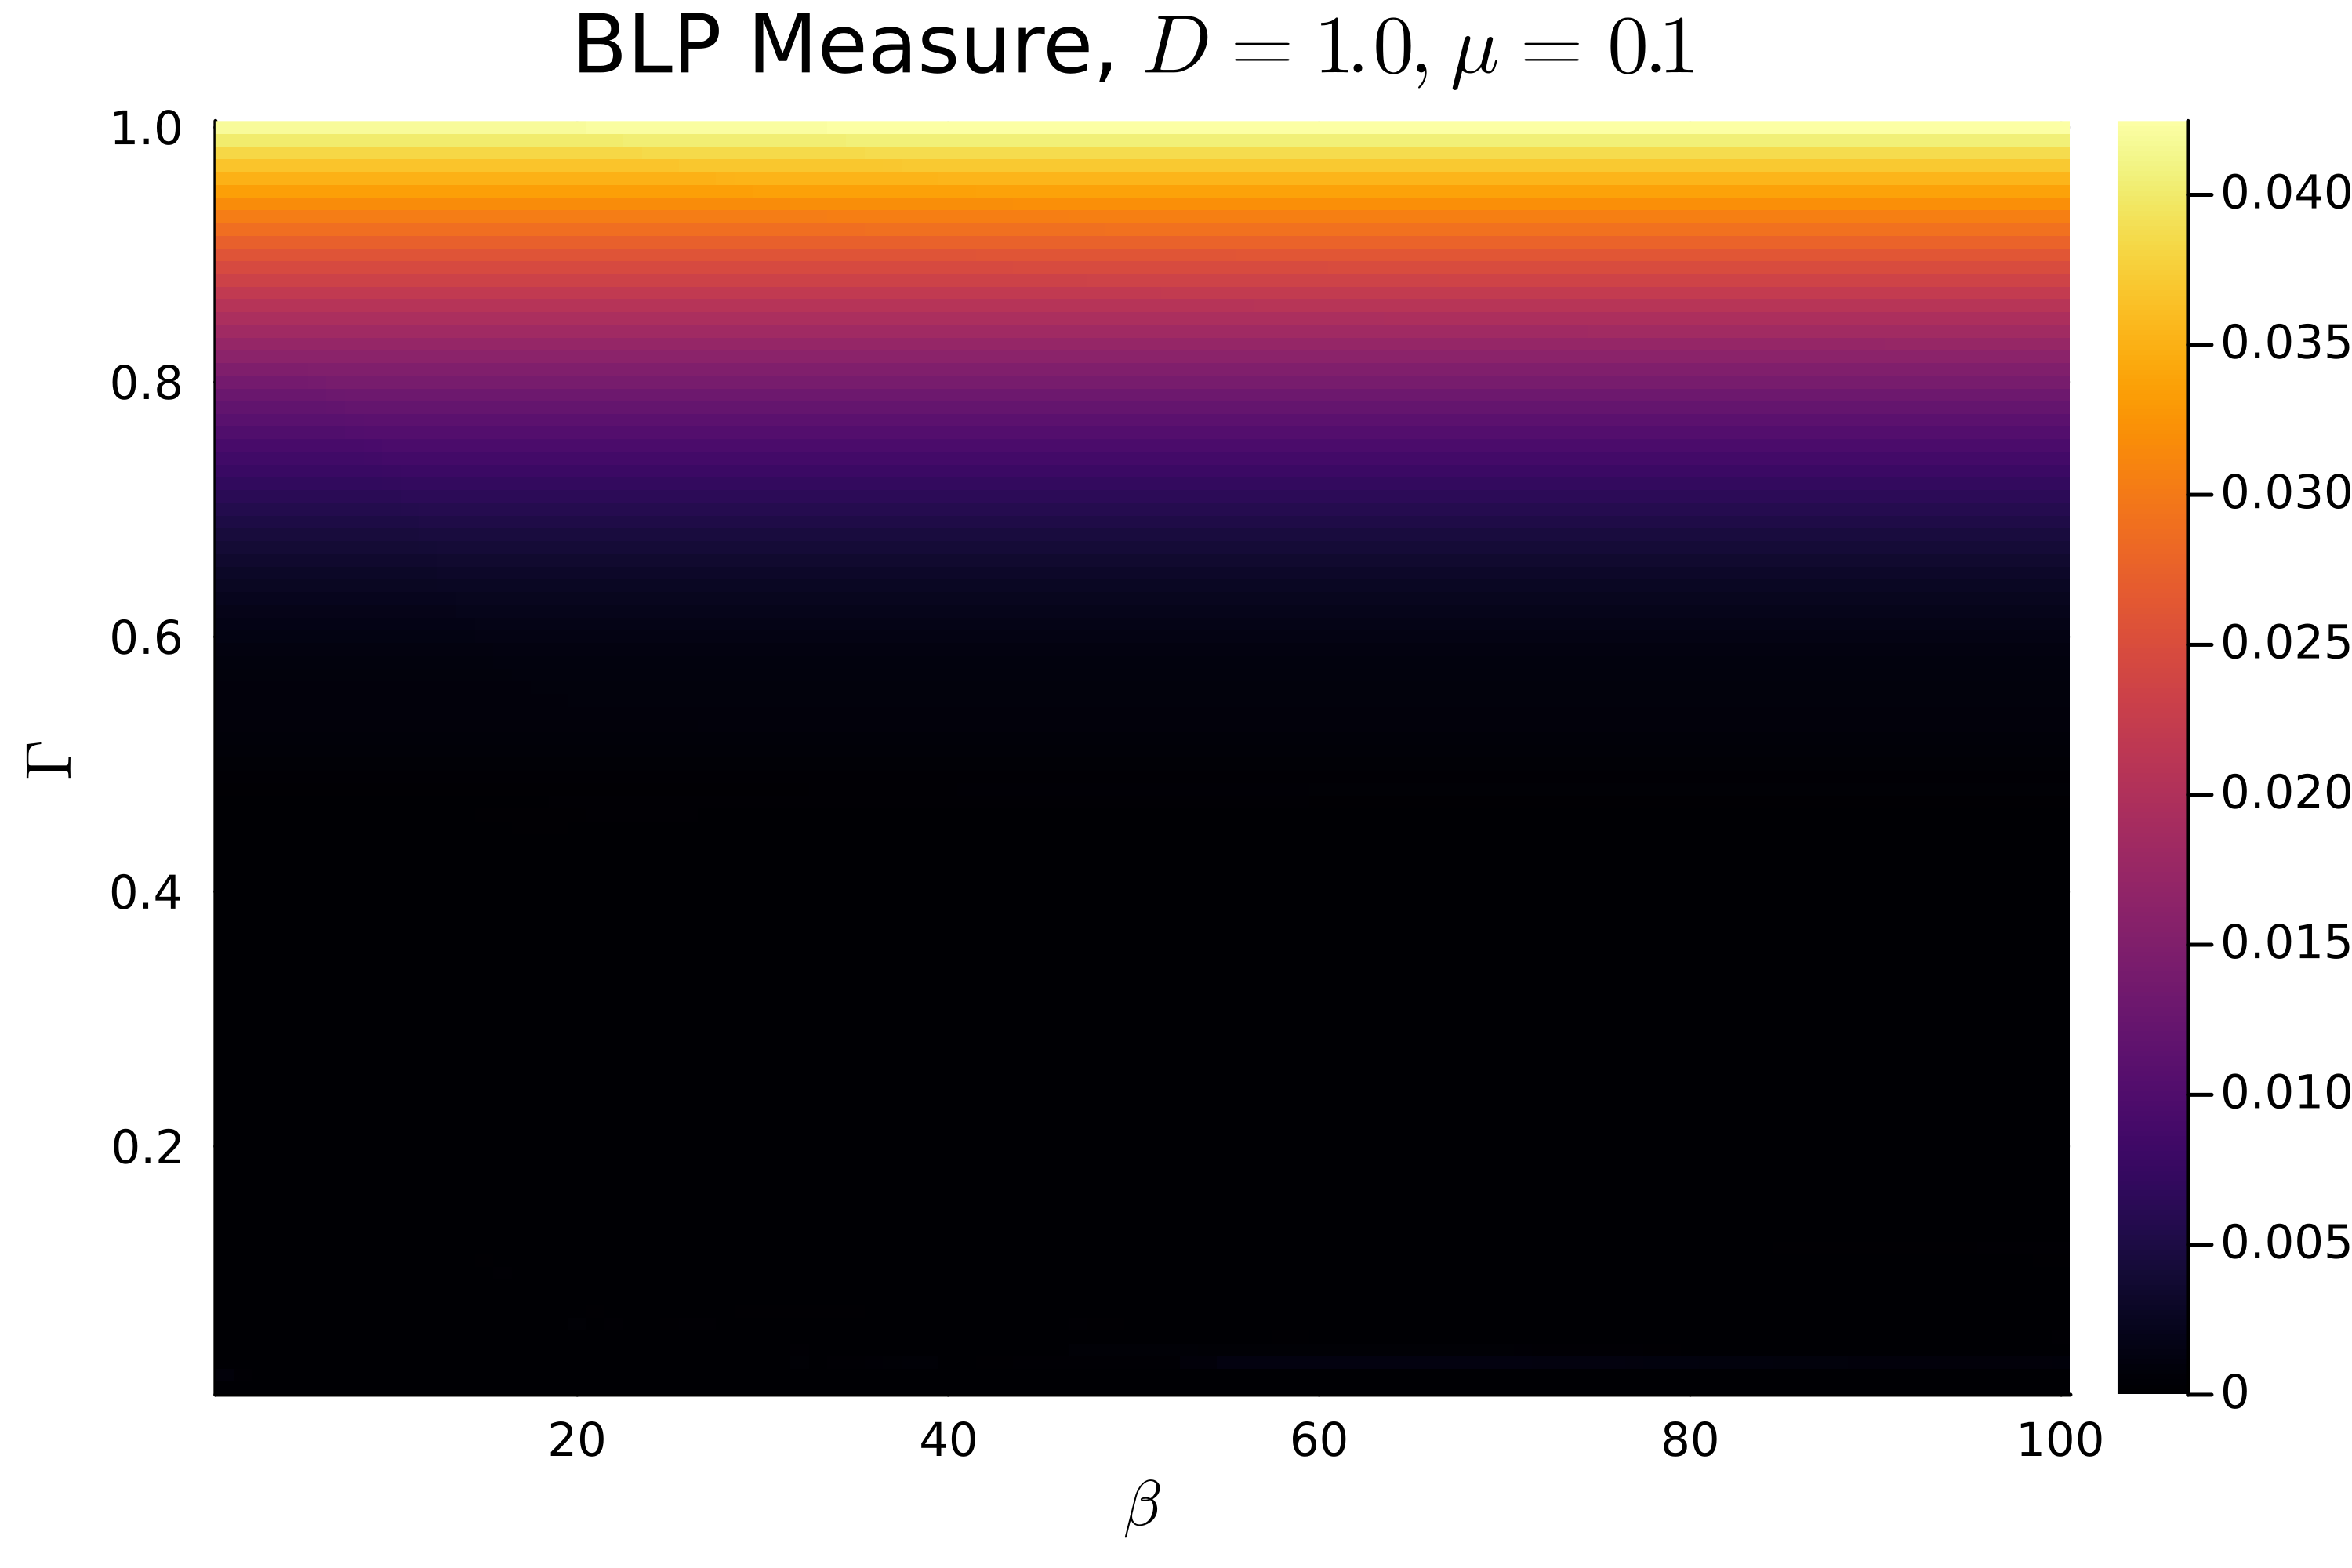

"C:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\2ndTerm\\images\\BLPheatmap_mu0.1_D1.0.png"

In [3]:
h = heatmap(betas, gs, BLP_data, ylabel="\$\\Gamma\$", xlabel="\$\\beta\$", title="BLP Measure, \$D=$D,\\mu=$mu\$", dpi=500)

display(h)
savefig(h,"C:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\2ndTerm\\images\\BLPheatmap_mu$(mu)_D$(D).png")



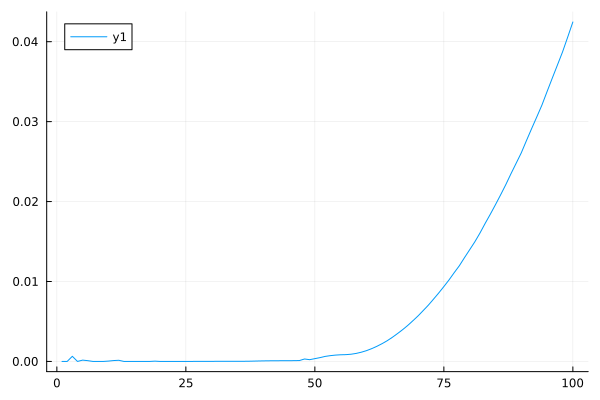

In [7]:
plot(BLP_data[:,100])

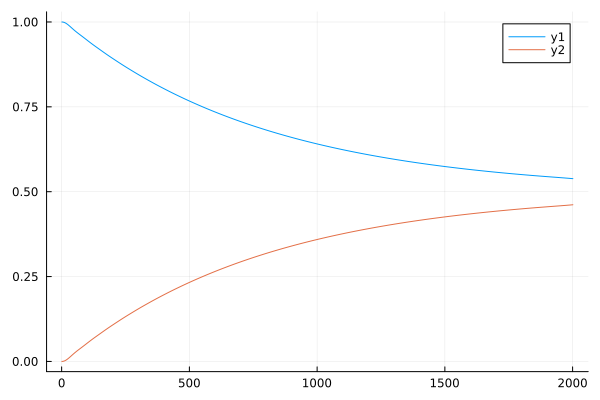

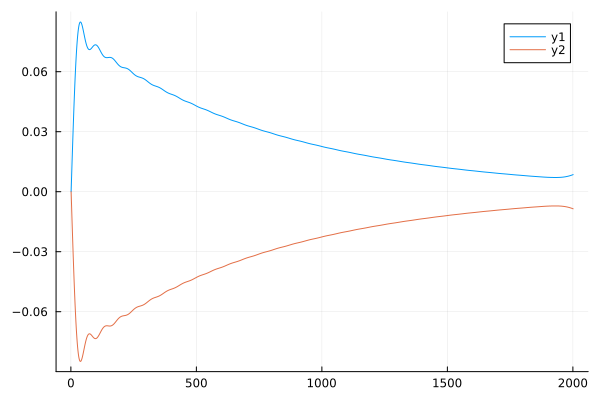

In [9]:
N=100
g = 0.01
beta = 10.0
mu = 0.0
D=1.0

Es = 0.0
dt = 0.1

J = SpectralFunc("elliptical", D, g)
J1, J2 = ThermofieldTransform(J, beta, mu)
E1, h1 = ChainMap(J1, N, D)
E2, h2 = ChainMap(J2, N, D)
C0f = PrepareCorrs(N, 1.0) 
C0e = PrepareCorrs(N, 0.0)
H = HamiltonianCorrs(N, Es, E1, h1, E2, h2)
Csf = EvolveCorrs(C0f, H, dt, N)
Cse = EvolveCorrs(C0e, H, dt, N)
rho1 = [real(C[N+1, N+1]) for C in Csf]
rho2 = [real(C[N+1, N+1]) for C in Cse]
flux_diff1 = [imag(M[N+1,N+2] - M[N,N+1]) for M in Csf]
flux_diff2 = [imag(M[N+1,N+2] - M[N,N+1]) for M in Cse]

p1 = plot(rho1)
plot!(rho2)
display(p1)

p2 = plot(flux_diff1)
plot!(p2, flux_diff2)
display(p2)

┌ Info: Saved animation to C:\Users\ben_b\AppData\Local\Temp\jl_zoVEJW1KlA.gif
└ @ Plots C:\Users\ben_b\.julia\packages\Plots\8ZnR3\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\ben_b\\AppData\\Local\\Temp\\jl_zoVEJW1KlA.gif")
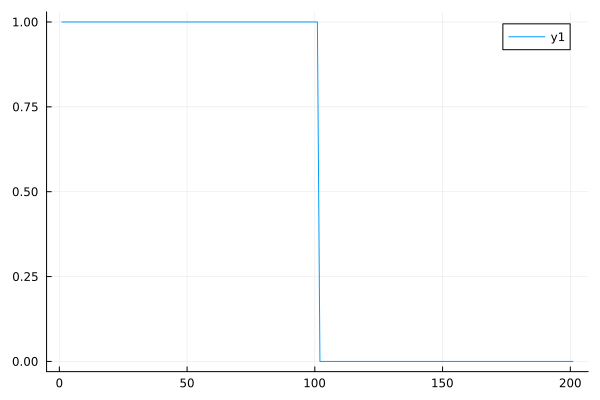

In [12]:
anim = @animate for C in Csf
    p = plot([real(C[n,n]) for n in 1:2N+1])
end

gif(anim, fps=25)